In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import DBSCAN

### Helpers for using DBSCAN to create clusters and viewing them

In [68]:
def DBSCAN_label_subset(filename, eps, min_samples, l_type = None, l_prop = None):
    df = pd.read_csv(filename, delimiter='\t')
    
    # dbscan expects multiple dimensions
    df["zeros"]=0
    
    # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values_w_0s = df.loc[:, ["node2", "zeros"]]
    values = values_w_0s.loc[:,"node2"]
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(values_w_0s)

    return (db, values)

def view_db_clustering(db, values, min_hist_bin = None, max_hist_bin = None):
    if min_hist_bin is None:
        min_hist_bin = values.min() - 1
    if max_hist_bin is None:
        max_hist_bin = values.max() + 1
    
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)


    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    ax = plt.gca()
    ax.set_facecolor("xkcd:silver")

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = values.loc[class_member_mask]
        plt.hist(xy, color=tuple(col), bins = range(min_hist_bin, max_hist_bin, 1))

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

File paths for passing in python

In [20]:
path = "/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/"
year_file = "{}Q44.entity_attribute_labels_time.year.tsv".format(path)


File paths for using in kgtk commands

In [21]:
work_dir = "/Users/nicklein/Documents/grad_school/Research/data"

In [26]:
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(work_dir)
os.environ['DATA'] = "{}/Q44".format(work_dir)
os.environ['NAME'] = "Q44"
os.environ["OUT"] = "{}/Q44_profiler_output".format(work_dir)

## year values

Taking a look at most prevalent type, property pairs

In [30]:
!head -5 $OUT/$NAME.entity_attribute_labels_time.year.tsv | column -t -s $'\t'

entity     node1     label  node2  type_label            property_label  id
Q1019      Q112099   P571   1960   'island nation'@en    'inception'@en  E1
Q1019      Q3624078  P571   1960   'sovereign state'@en  'inception'@en  E2
Q10272528  Q4830453  P571   1872   'business'@en         'inception'@en  E3
Q1033      Q3624078  P571   1960   'sovereign state'@en  'inception'@en  E4


In [90]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val)' \
--return 'type as type, p as prop, count(e) as count, t_lab as type_label, p_lab as property_label' \
--order-by 'count(e) desc' \
--limit 5 \
| column -t -s $'\t'

type      prop  count  type_label            property_label
Q4830453  P571  43     'business'@en         'inception'@en
Q131734   P571  38     'brewery'@en          'inception'@en
Q3624078  P571  30     'sovereign state'@en  'inception'@en
Q6881511  P571  20     'enterprise'@en       'inception'@en
Q6256     P571  9      'country'@en          'inception'@en


Let's start by looking at year values for type = **business** prop = **inception**

First let's take a look at what triples match these labels...

In [96]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv -i $DATA/$NAME.label.en.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val), label: (e)-[:label]->(e_lab)' \
--return 'distinct e as entity, type as type, p as prop, val as year, e_lab as entity_label, t_lab as type_label, p_lab as property_label' \
--where 'type = "Q4830453" AND p = "P571" AND e_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'kgtk_quantity_number_int(val)' \
--limit 10 \
| column -t -s $'\t'

entity     type      prop  year  entity_label                    type_label     property_label
Q562552    Q4830453  P571  1333  'Oettinger Brewery'@en          'business'@en  'inception'@en
Q153075    Q4830453  P571  1615  'Grolsch Brewery'@en            'business'@en  'inception'@en
Q1397604   Q4830453  P571  1664  'Kronenbourg Brewery'@en        'business'@en  'inception'@en
Q12002324  Q4830453  P571  1698  'Shepherd Neame Brewery'@en     'business'@en  'inception'@en
Q1164954   Q4830453  P571  1769  'Dubuisson Brewery'@en          'business'@en  'inception'@en
Q609966    Q4830453  P571  1795  'Budweiser Bier Bürgerbräu'@en  'business'@en  'inception'@en
Q2601227   Q4830453  P571  1819  'Sinebrychoff'@en               'business'@en  'inception'@en
Q3640368   Q4830453  P571  1846  'Peroni'@en                     'business'@en  'inception'@en
Q865859    Q4830453  P571  1846  'Peroni Brewery'@en             'business'@en  'inception'@en
Q113215    Q4830453  P571  1847  'Carlsberg Group'

eps = 5, minpts = 1

Estimated number of clusters: 18
Estimated number of noise points: 0


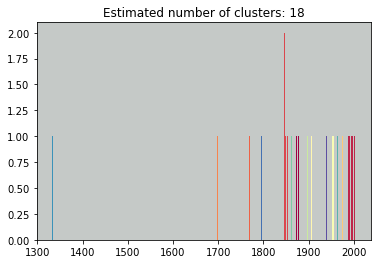

In [82]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 5, min_samples = 1)
view_db_clustering(db_bus_incep, values_bus_incep)

zooming in...

Estimated number of clusters: 18
Estimated number of noise points: 0


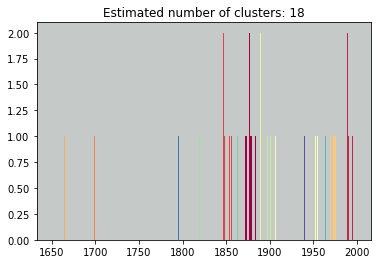

In [83]:
view_db_clustering(db_bus_incep, values_bus_incep, 1650, 2000)

eps = 10, minpts = 1

Estimated number of clusters: 11
Estimated number of noise points: 0


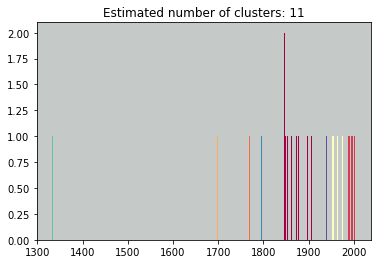

In [84]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 10, min_samples = 1)
view_db_clustering(db_bus_incep, values_bus_incep)

zooming in...

Estimated number of clusters: 11
Estimated number of noise points: 0


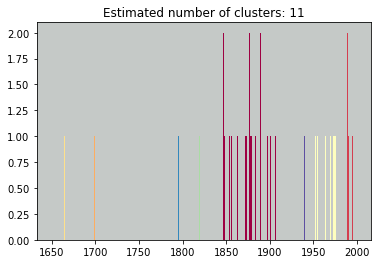

In [85]:
view_db_clustering(db_bus_incep, values_bus_incep, 1650, 2000)

eps = 5, minpts = 10

Estimated number of clusters: 7
Estimated number of noise points: 11


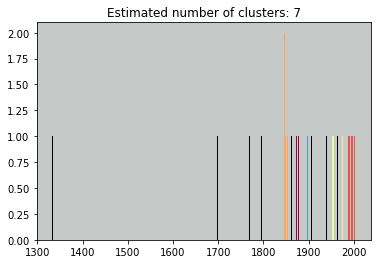

In [78]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 5, min_samples = 2)
view_db_clustering(db_bus_incep, values_bus_incep)

zooming in...

Estimated number of clusters: 7
Estimated number of noise points: 11


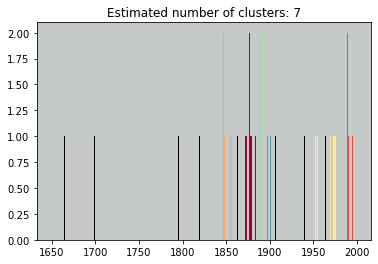

In [81]:
view_db_clustering(db_bus_incep, values_bus_incep, 1650, 2000)

Let's also look at year values for type = **brewery** prop = **inception**

triples that match this type and property:

In [97]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv -i $DATA/$NAME.label.en.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val), label: (e)-[:label]->(e_lab)' \
--return 'distinct e as entity, type as type, p as prop, val as year, e_lab as entity_label, t_lab as type_label, p_lab as property_label' \
--where 'type = "Q131734" AND p = "P571" AND e_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'kgtk_quantity_number_int(val)' \
--limit 10 \
| column -t -s $'\t'

entity     type     prop  year  entity_label                 type_label    property_label
Q153546    Q131734  P571  1328  'Augustiner Bräu'@en         'brewery'@en  'inception'@en
Q562552    Q131734  P571  1333  'Oettinger Brewery'@en       'brewery'@en  'inception'@en
Q566990    Q131734  P571  1405  'Schlenkerla'@en             'brewery'@en  'inception'@en
Q3508302   Q131734  P571  1564  'Svijany Brewery'@en         'brewery'@en  'inception'@en
Q153075    Q131734  P571  1615  'Grolsch Brewery'@en         'brewery'@en  'inception'@en
Q1397604   Q131734  P571  1664  'Kronenbourg Brewery'@en     'brewery'@en  'inception'@en
Q12002324  Q131734  P571  1698  'Shepherd Neame Brewery'@en  'brewery'@en  'inception'@en
Q2319266   Q131734  P571  1759  'Guinness Brewery'@en        'brewery'@en  'inception'@en
Q1164954   Q131734  P571  1769  'Dubuisson Brewery'@en       'brewery'@en  'inception'@en
Q2754546   Q131734  P571  1825  'Gulpener Brewery'@en        'brewery'@en  'inception'@en


In [79]:
db_brew_incep, values_brew_incep = DBSCAN_label_subset(year_file, l_type = "Q131734", l_prop = "P571", eps = 8, min_samples = 1)

Estimated number of clusters: 16
Estimated number of noise points: 0


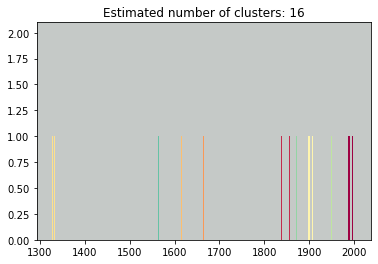

In [80]:
view_db_clustering(db_brew_incep, values_brew_incep)

Estimated number of clusters: 16
Estimated number of noise points: 0


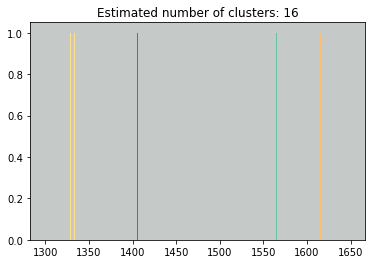

In [61]:
view_db_clustering(db_brew_incep, values_brew_incep, 1300, 1650)

Estimated number of clusters: 16
Estimated number of noise points: 0


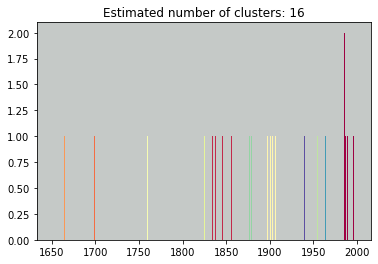

In [62]:
view_db_clustering(db_brew_incep, values_brew_incep, 1650, 2000)